In [9]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import spacy

import matplotlib.pyplot as plt
import clean_dataset as clean
import make_dataset as mk
import vectorize_embed as em
import tools as tools

import pickle
import numpy as np

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline


import seaborn as sns

In [10]:
'''import data'''


df = pd.read_json(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/main_landscapes_all.json')  
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)

conserved_areas = pd.read_excel(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/Conserved_Areas.xlsx')  


In [11]:
df_trunc = mk.truncate(df, 600, save=False)
df_trunc.shape

_________________________
PIMS ID: 2564.0

the primary goal of the national capacity selfassessment ncsa is to identify through a countrydriven consultative process priorities and needs for capacity building to protect the global environment
_________________________
PIMS ID: 3807.0

at national level strengthen national capacity to develop and apply sustainable ficing mechanisms for sustainable land management at local level introduce in the cpp the theme of forest ecosystems
_________________________
PIMS ID: nan

nan
_________________________
PIMS ID: 4186.0

the project aims to develop and institutionalize a multipleuse forest landscape and planning model which brings the management of critical pas in sabah and the surrounding landscapes under a common management umbrella the project will develop and demonstrate a model by which the management costs of these pas will be underwritten by the sustainable revenue streams generated by surrounding forest landscapes compensating for the e

(553, 17)

In [12]:
df_trunc.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'forest', 'tundra',
       'conserved_areas', 'freshwater', 'grassland', 'desert', 'marine',
       'wetlands', 'human_altered_areas', 'no tag', 'category_1', 'category_2',
       'category_3', 'labels'],
      dtype='object')

In [13]:
#Holding out 5 rows from the original dataframe for prediction at the end
df_holdout = df_trunc.iloc[:10]

df_trunc = df_trunc.iloc[10:]

train size: 380
test size: 163
C equals: 10

Training accuracy: 0.989
Test accuracy: 0.828
f1 score: 0.7680894308943089


label_1    abs
dtype: object

C equals: 5

Training accuracy: 0.974
Test accuracy: 0.822
f1 score: 0.7618039808516


label_1    pa
dtype: object

C equals: 1

Training accuracy: 0.942
Test accuracy: 0.816
f1 score: 0.7594451003541913


label_1    conservation
dtype: object

C equals: 0.1

Training accuracy: 0.932
Test accuracy: 0.81
f1 score: 0.760441852747357


label_1    conservation
dtype: object

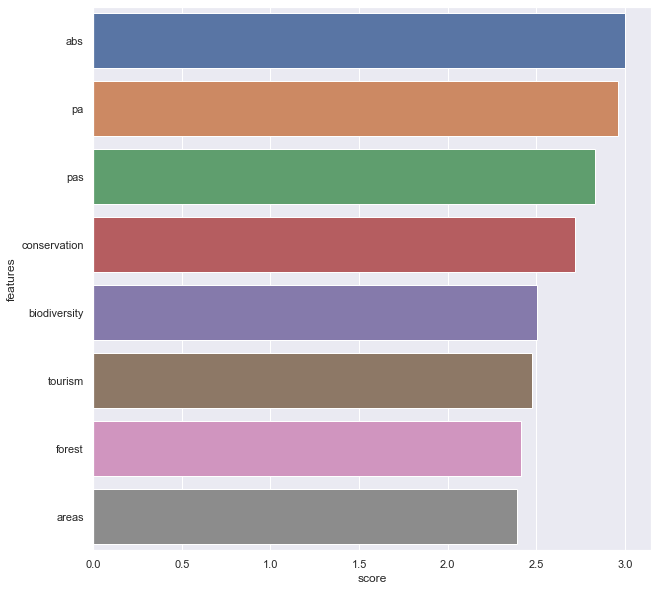

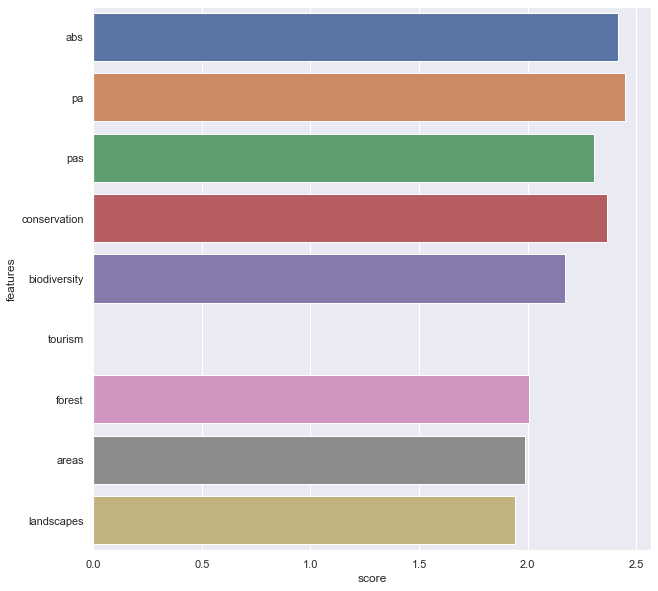

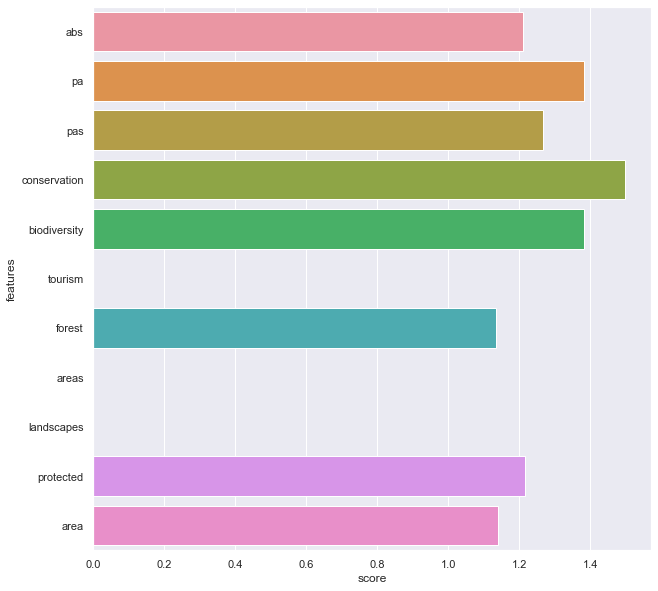

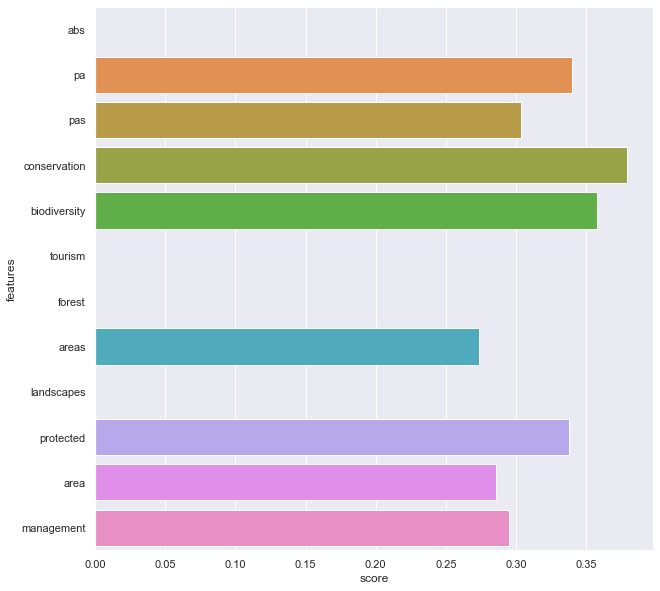

In [14]:
df_regressors = pd.DataFrame(columns = ["label", "features", "score"])


X_train, X_test, y_train, y_test = train_test_split(df_trunc['all_text_clean'],
                                                    df_trunc['conserved_areas'].values,
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)


vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)




#add additional feature weight
"""
vect = vectorizer.fit(X_train)
query_vec = vect.transform(X_train)

weight = 10

position = vect.vocabulary_['ews']
query_vec[:, position] *= weight

position = vect.vocabulary_['early warning']
query_vec[:, position] *= weight
"""


C = [10, 5, 1, 0.1]

for c in C:
    print('C equals:', c)
    clf = LogisticRegression(penalty='l2', solver = 'lbfgs', class_weight= 'balanced', C = c).fit(X_train, y_train)
    print('')
    print('Training accuracy:', clf.score(X_train, y_train).round(3))
    print('Test accuracy:', clf.score(X_test, y_test).round(3))
    y_hat = clf.predict(X_test)
    print('f1 score:', f1_score(y_test, y_hat, average="macro"))

    #top regressors 
    #return top  regressors and convert to dataframe for visualisation:
    df_lambda = tools.get_topwords(clf, vectorizer, n = 8, n_models = 1, show_idxmax = True)
    keywords = df_lambda.Keywords.iloc[0]

    for key in keywords:

        df_regressors = df_regressors.append({'label': 'conserved_areas', "features":key}, ignore_index=True)
        df_regressors['features'] = df_regressors['features'].astype(str)
        df_regressors['features'] = df_regressors['features'].str.replace('(','')
        df_regressors['features'] = df_regressors['features'].str.replace(')','')
        df_regressors['features'] = df_regressors['features'].str.replace("'",'')               


    df_regressors[['features','score']] = df_regressors['features'].str.split(',',expand=True)
    df_regressors['score'] = df_regressors['score'].astype(float)    
    plt.figure(figsize=(10,10))
    sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df_regressors)